In [25]:
!pip install -r /kaggle/input/bci-mini-project/requirements.txt

In [49]:
!pip install torch

In [26]:
%matplotlib inline
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import stft, ricker, cwt, butter, iirnotch, lfilter
import scipy.stats as stats
import pywt
from tqdm import tqdm
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

import torch

import mne

from statsmodels.stats.weightstats import ztest

In [27]:
sample_frequency = 256 #Hz
bandpass_filter = (0, 30) # Hz
stimulus_duration = 125 #ms
interstimulus_interval = 125 #ms
total_stimulus = 12 # 6 rows and 6 columns
number_of_times_each_stimulus_appeared_per_trial = 10
total_stimulus_appeared_per_trial = total_stimulus * number_of_times_each_stimulus_appeared_per_trial

trial_duration = (stimulus_duration * total_stimulus_appeared_per_trial) + \
(interstimulus_interval * (total_stimulus_appeared_per_trial- 1))

samples_per_trial = (sample_frequency * trial_duration)//1000


# Load Data

In [28]:
def load_data(filepath):
    """
    Loads EEG signal from the dataset
    """
    sample_matlab_data = scio.loadmat(filepath)  # Structured Matlab Array containing all information
    return sample_matlab_data

basedir = '/kaggle/input/bci-mini-project/Data'

In [29]:
patient_data = []
for file in os.listdir(basedir):
    filepath = os.path.join(basedir, file)
    patient_data.append(load_data(filepath))
    
print(len(patient_data))

8


In [30]:
def get_channel_name(patient, index):
    """
    Returns the name of the EEG channel for the corresponding index
    """
    return patient['data'][0][0]['channels'][0][index]
print(get_channel_name(patient_data[0], 1))

['Cz']


In [31]:
def get_channel_index(patient, channel_name):
    """
    Returns the index number of a channel
    """
    indices = [data[0].lower() for data in patient['data'][0][0]['channels'][0]]
    return indices.index(channel_name.lower())
print(get_channel_index(patient_data[0], 'Fz'))

0


In [32]:
import os
import pickle

# Folder path
folder_path = '/kaggle/input/bci-mini-project/cleaned_data'

# File paths
x_file_path = os.path.join(folder_path, 'x.pkl')
y_file_path = os.path.join(folder_path, 'y.pkl')

# Load data
with open(x_file_path, 'rb') as f:
    X = pickle.load(f)

with open(y_file_path, 'rb') as f:
    y = pickle.load(f)



In [33]:
X.shape, y.shape

((8, 7, 5, 7648, 8), (8, 7, 5, 7648))

X: patients, number_of_run, number_of_trials_per_run, samples of signals, channels

y_target: patients, number_of_run, number_of_trials_per_run, samples

# Extract feature

In [34]:
def create_data(x,y,show_progress=False,get_delayed_samples=0):
    """
    Input X: (patients, number_of_run, number_of_trials_per_run, samples of signals, channels)
    Input y: patients, number_of_run, number_of_trials_per_run, samples
    Output X: (Data, samples, channels)
    Output y: (Data, samples)
    """
    x=x.reshape ((x.shape[0],x.shape[1]*x.shape[2]*x.shape[3],x.shape[4]))
    y=y.reshape ((y.shape[0],y.shape[1]*y.shape[2]*y.shape[3]))

    x_output=[]
    y_output=[]

    waveform_start_time_after_onset = 0
    waveform_start_sample_after_onset = int(sample_frequency * waveform_start_time_after_onset / 1000)
    
    stimulus_samples = 256*stimulus_duration//1000
    waveform_end_sample_after_onset = stimulus_samples + get_delayed_samples

    for patient in range(x.shape[0]):
        val = range(x.shape[1])
        if show_progress:
            val = tqdm(val)
        for sample in val:
            if (y[patient, sample] != 0) and  (y[patient, sample-1] != y[patient, sample]): # start of onset
                if sample + waveform_end_sample_after_onset < y.shape[-1]:
                    x_output.append(x[patient, sample+waveform_start_sample_after_onset:sample+waveform_end_sample_after_onset, :])
                    y_output.append(y[patient, sample])
    
    return np.array(x_output), np.array(y_output)

In [35]:
samples_per_class = 17*12
additional_samples = samples_per_class - (256*stimulus_duration//1000)
x, y = create_data(X,y,show_progress=True, get_delayed_samples=additional_samples)


100%|██████████| 267680/267680 [00:00<00:00, 544720.09it/s]


In [36]:
x = x.transpose((0, 2, 1))
y=y-1
cnames = ['Pz', 'Oz', 'PO7', 'PO8']
c = []
for n in cnames:
    c.append(get_channel_index(patient_data[0], n))
x = x[:, c, :] 
x = x.reshape((x.shape[0], x.shape[1], 17, 12)).mean(axis=-1)
x, y = shuffle(x, y, random_state=12432)
X_data = x.copy()
y_data = y.copy()
x = x.reshape((x.shape[0], -1))
print(x.shape)

(33576, 68)


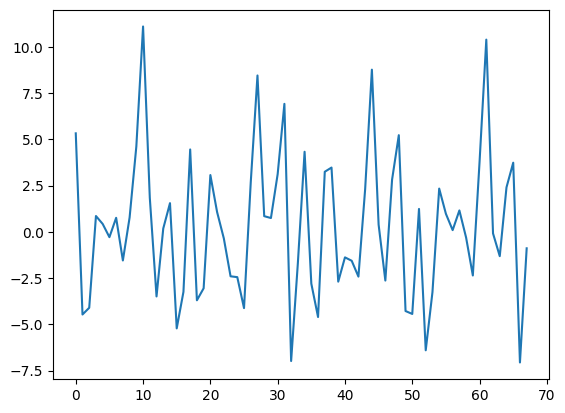

In [37]:
plt.figure()
plt.plot(x[2, :])
plt.show()

In [38]:
np.unique(y)

array([0, 1], dtype=uint8)

In [39]:
# Balancing the dataset
data_per_class = 5600
indices = np.concatenate((np.where(y == 0)[0][:data_per_class], np.where(y == 1)[0][:data_per_class]))
x = x[indices, :]
y = y[indices]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6150)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8960, 68) (8960,) (2240, 68) (2240,)


# PCA

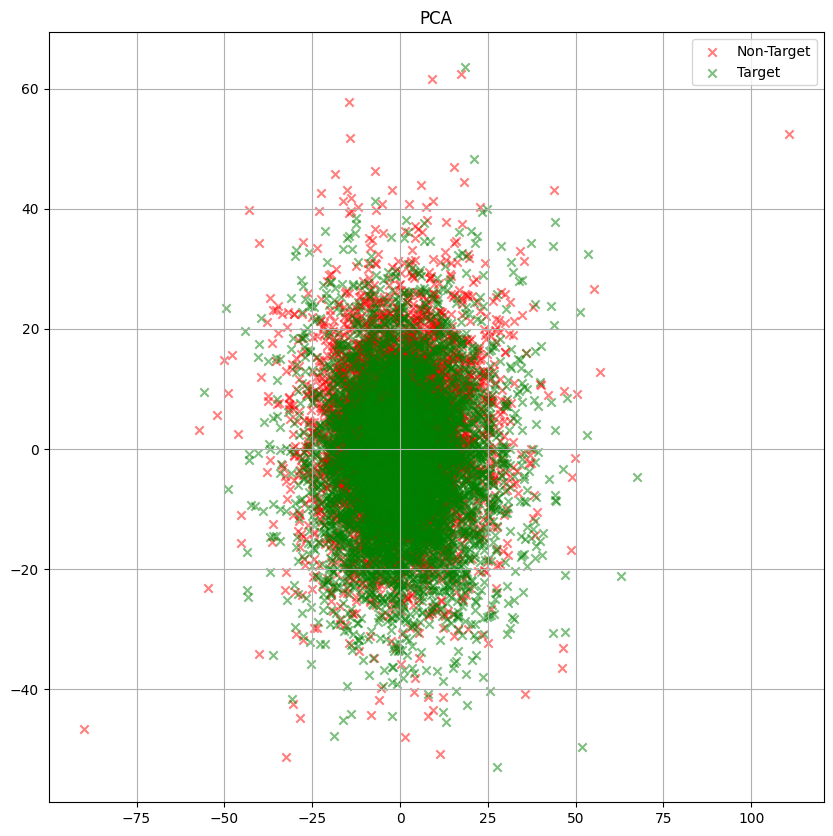

In [41]:

a =  PCA(n_components=35).fit(x).transform(x)
plt.figure(figsize=(10, 10))
plt.title("PCA")
plt.scatter(a[y == 0, 0], a[y == 0, 1], label='Non-Target', color='r', alpha=0.5, marker='x')
plt.scatter(a[y == 1, 0], a[y == 1, 1], label='Target', color='g', alpha=0.5, marker='x')
plt.grid()
plt.legend()
plt.show()

# Stepwise LDA

In [42]:
class StepwiseLDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.classes = []
        self.eigenpairs = []
        self.weights = None
        
    def transform(self, x):
        if self.weights is None:
            raise ValueError("Please fit the model before using it")
            
        return x.dot(self.weights)
        
        
        
    def fit(self, x, y):
        self.classes = np.unique(y)
        
        # Calculate mean vectors
        mean_vectors = []
        for c in self.classes:
            mean_vectors.append(np.mean(x[y == c], axis=0))
        mean_vectors = np.array(mean_vectors)
        
        
        
        s_w = np.zeros((x.shape[1],x.shape[1]))  # Create scatter within matrix for each feature
        s_b = np.zeros((x.shape[1],x.shape[1]))  # Between Class Scatter Matrix
        overall_mean = np.mean(x, axis=0).reshape(x.shape[1],1)  # Mean for all classes
        
        for cl, mv in zip(self.classes, mean_vectors):  # For each class and its corresponding mean vector
            mv = mv.reshape(x.shape[1],1) # transpose mean vector of the current class
            x_target = x[y==cl]  # Calculate size/total no. of feature vectors in the current class
            n = x_target.shape[0]
            
            # Calculate within-class Scatter matrix
            class_sc_mat = np.zeros((x.shape[1],x.shape[1]))                  # scatter matrix for every class
            for row in x_target:
                row = row.reshape(x.shape[1],1) # make column vectors
                class_sc_mat += (row-mv).dot((row-mv).T)
            
            s_w += class_sc_mat                             # sum class scatter matrices
            
            # calculate between-class scatter matrix            
            s_b += n * (mv - overall_mean).dot((mv - overall_mean).T)  # Calculate Between class scatter matrix
            
        # Compute Eigen Value and Eigenvector for the dot product between the two matrices
        eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(s_w).dot(s_b))
        
        
        # Make a list of (eigenvalue, eigenvector) tuples
        self.eigenpairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        self.eigenpairs = sorted(self.eigenpairs, key=lambda k: k[0], reverse=True)
        
        # Calculate weights
        self.weights = self.eigenpairs[0][1].reshape(x.shape[1],1)
        #W = np.hstack((, eig_pairs[1][1].reshape(x_tr_an.shape[1],1)))
        for i in range(1, self.n_components):
            self.weights = np.hstack((self.weights, self.eigenpairs[i][1].reshape(x.shape[1],1)))
            
        return self

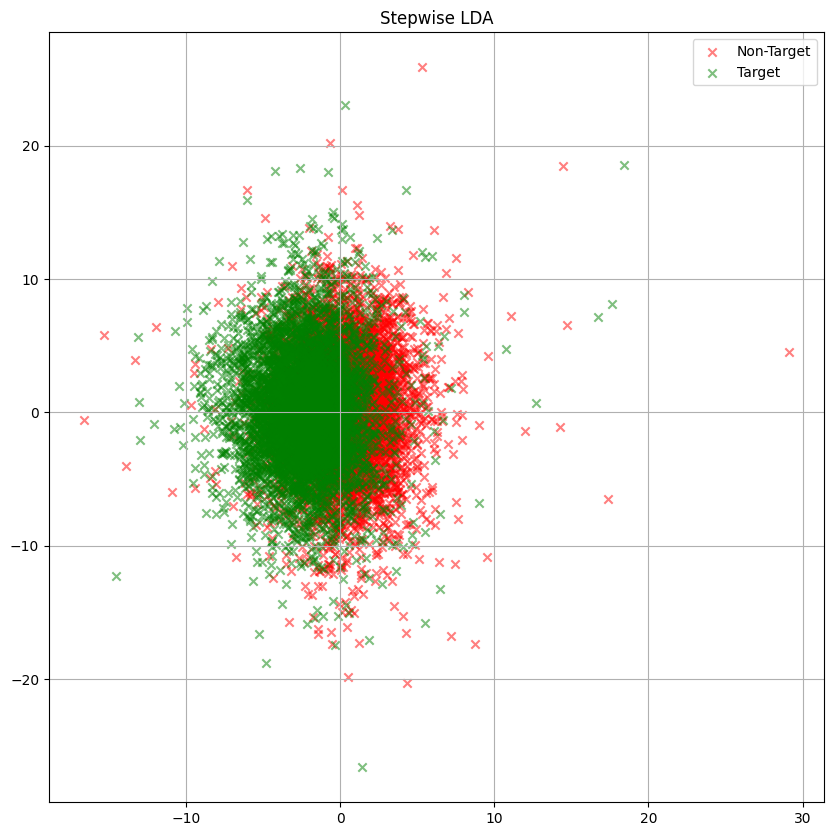

In [43]:
a =  StepwiseLDA(n_components=35).fit(x, y).transform(x)
plt.figure(figsize=(10, 10))
plt.title("Stepwise LDA")
plt.scatter(a[y == 0, 0].real, a[y == 0, 1].real, label='Non-Target', color='r', alpha=0.5, marker='x')
plt.scatter(a[y == 1, 0].real, a[y == 1, 1].real, label='Target', color='g', alpha=0.5, marker='x')
plt.grid()
plt.legend()
plt.show()

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
clf = RandomForestClassifier(max_depth=50, random_state=26784)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print metrics
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")


Accuracy: 63.62%
Precision: 63.61%
Recall: 63.62%
F1 Score: 63.61%


In [83]:
pca = PCA(n_components=35)
pca.fit(X_train, y_train)
a, b = pca.transform(X_train), pca.transform(X_test)
clf = RandomForestClassifier(max_depth=10, random_state=100)
clf.fit(a, y_train)

y_pred = clf.predict(b)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print metrics
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")


Accuracy: 66.21%
Precision: 66.32%
Recall: 66.21%
F1 Score: 66.19%


In [85]:
lda = StepwiseLDA(n_components=35)
lda.fit(X_train.numpy(), y_train.numpy())
a, b = lda.transform(X_train.numpy()), lda.transform(X_test.numpy())
clf = RandomForestClassifier(max_depth=10, random_state=100)
clf.fit(a, y_train)

y_pred = clf.predict(b)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print metrics
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")


Accuracy: 73.30%
Precision: 73.31%
Recall: 73.30%
F1 Score: 73.29%


In [47]:

X_train, X_test = torch.tensor(X_train, requires_grad=False).float(), torch.tensor(X_test, requires_grad=False).float()
y_train, y_test = torch.tensor(y_train, requires_grad=False).type(torch.LongTensor), torch.tensor(y_test, requires_grad=False).type(torch.LongTensor)

In [58]:
@torch.no_grad()
def calculate_accuracy(prediction, true_labels):
    prediction_classes = torch.argmax(prediction, axis=1)
    return (prediction_classes == true_labels).float().mean()
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(prediction, true_labels):
    """
    Calculate accuracy, precision, recall, and F1-score.

    Parameters:
    - prediction: Torch tensor with raw model outputs (logits).
    - true_labels: Torch tensor with true labels (class indices).

    Returns:
    - metrics: Dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Convert logits to predicted classes
    prediction_classes = torch.argmax(prediction, axis=1)
    
    # Convert to numpy for sklearn metrics
    pred_np = prediction_classes.cpu().numpy()
    true_np = true_labels.cpu().numpy()

    # Calculate metrics
    accuracy = (prediction_classes == true_labels).float().mean().item()
    precision = precision_score(true_np, pred_np, average='weighted', zero_division=0)
    recall = recall_score(true_np, pred_np, average='weighted', zero_division=0)
    f1 = f1_score(true_np, pred_np, average='weighted', zero_division=0)

    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
def train(epochs, batch_size, loss_function, optimizer, model, x, y, print_every=200, learning_rate_decay=None):
    train_accuracy = []
    train_loss = []
    vals = tqdm(range(epochs), desc=f'Epoch: 0, train loss: -, Accuracy: -')
    
    scheduler = None
    if not (learning_rate_decay is None):
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learning_rate_decay)
    
    for epoch in vals:
        avg_cost = 0
    
        # Shuffle training data
        dataset = torch.randperm(x.shape[0])
        
        # For each batch
        for batch in range(0, dataset.size()[0], batch_size):
            model.train()
            
            range_end = batch+batch_size
            if range_end + batch_size >= dataset.size()[0]:
                range_end = range_end+batch_size
            # Get train and test data
            x_batch = x[dataset[batch:range_end]]
            y_batch = y[dataset[batch:range_end]]
            
            # Forward pass
            optimizer.zero_grad()
            prediction = model(x_batch)
            
            # Calculate loss
            loss = loss_function(prediction, y_batch)

            # Backpropagation
            loss.backward() # Calculate gradient
            optimizer.step() # Upgrade gradients
            
        
            # Calculate metrics
            train_loss.append(loss.item())
            train_accuracy.append(calculate_accuracy(prediction, y_batch))
            
            if batch % print_every == 0:
                vals.set_description(f'Epoch: {epoch}, train loss: {train_loss[-1]:.5f}, Accuracy: {train_accuracy[-1]*100:3f}')
                
        if not (scheduler is None):
            scheduler.step() # Learning rate decay
                
    return train_loss, train_accuracy

In [59]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class ModelDNN(nn.Module):
    def __init__(self, input_size, num_classes, first_layer_neuron=1024, hidden_layers_neurons=[512], activation=nn.ReLU):
        """
        Simplified DNN Model for classification.

        Args:
        - input_size: Number of input features.
        - num_classes: Number of output classes.
        - first_layer_neuron: Number of neurons in the first layer.
        - hidden_layers_neurons: List defining the size of each hidden layer.
        - activation: Activation function to use (default: ReLU).
        """
        super(ModelDNN, self).__init__()

        self.layers = nn.ModuleList()
        
        # Add the first fully connected layer
        self.layers.append(
            nn.Sequential(
                nn.Linear(input_size, first_layer_neuron),
                activation(),
                nn.Dropout(0.4)
            )
        )

        # Add additional hidden layers
        for i, neurons in enumerate(hidden_layers_neurons):
            self.layers.append(
                nn.Sequential(
                    nn.Linear(first_layer_neuron if i == 0 else hidden_layers_neurons[i - 1], neurons),
                    activation(),
                    nn.Dropout(0.2)
                )
            )

        # Add the output layer
        self.out_fc = nn.Linear(hidden_layers_neurons[-1] if hidden_layers_neurons else first_layer_neuron, num_classes)

    def forward(self, x):
        """
        Forward pass through the network.
        """
        x = x.view(x.size(0), -1)  # Flatten input if required
        for layer in self.layers:
            x = layer(x)
        return self.out_fc(x)


Epoch: 49, train loss: 0.29639, Accuracy: 81.250000: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it] 


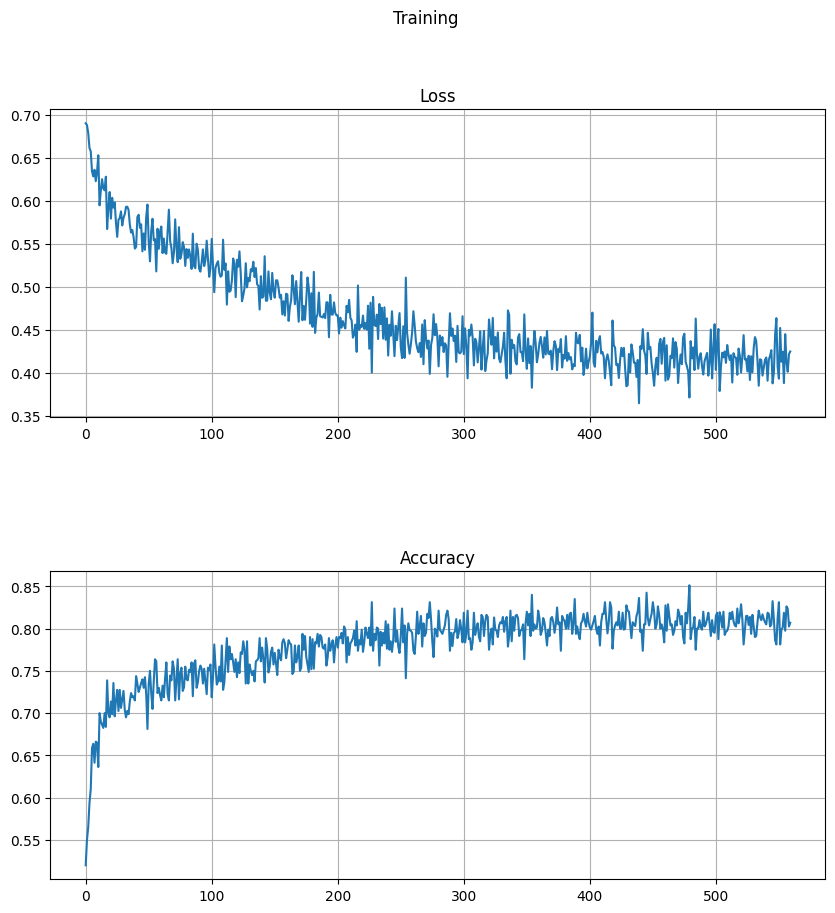

In [60]:
input_size = X_train.shape[1]
num_classes = len(torch.unique(y_train))

# Initialize the model
model = ModelDNN(input_size=input_size, num_classes=num_classes, first_layer_neuron=512, hidden_layers_neurons=[128, 64, 32, 16])
epochs = 50
batch_size = 16
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=X_train,
    y=y_train,
    print_every=200,
    learning_rate_decay=0.9
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [66]:
calculate_metrics(model(X_test), y_test)

{'accuracy': 0.7129464149475098,
 'precision': 0.7129107089818835,
 'recall': 0.7129464285714285,
 'f1_score': 0.7128658629555864}

Epoch: 49, train loss: 0.18959, Accuracy: 100.000000: 100%|██████████| 50/50 [02:37<00:00,  3.15s/it]


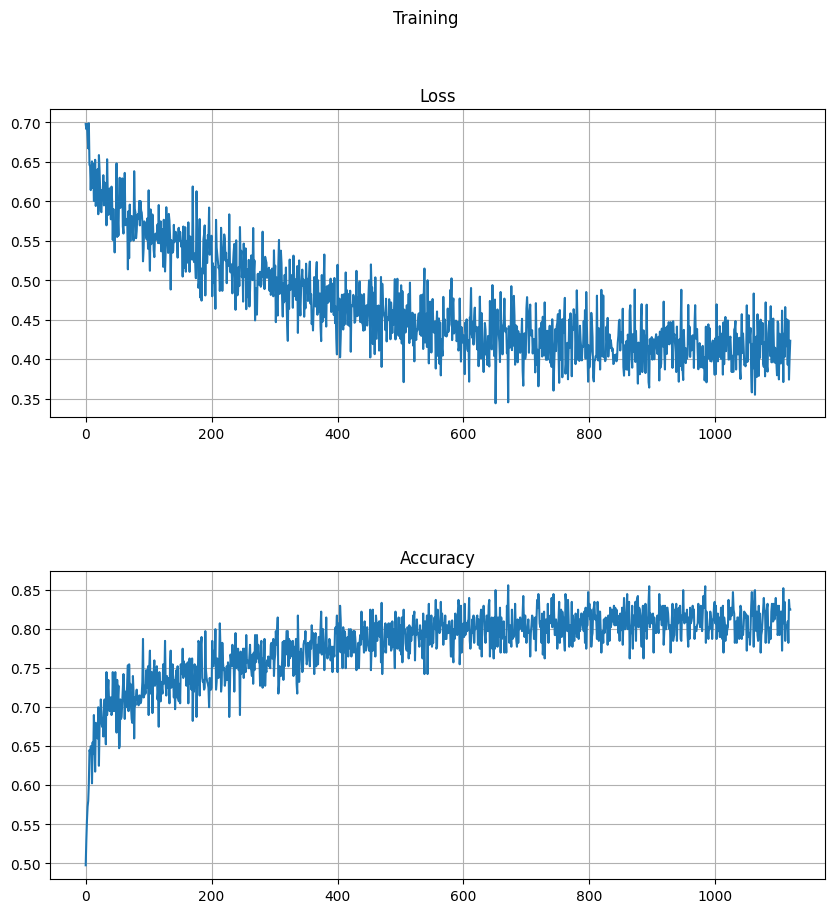

In [67]:
input_size = X_train.shape[1]
num_classes = len(torch.unique(y_train))

# Initialize the model
model = ModelDNN(input_size=input_size, num_classes=num_classes, first_layer_neuron=512, hidden_layers_neurons=[128, 64, 32, 16])
epochs = 50
batch_size = 8
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=X_train,
    y=y_train,
    print_every=200,
    learning_rate_decay=0.9
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [68]:
calculate_metrics(model(X_test), y_test)

{'accuracy': 0.7080357074737549,
 'precision': 0.7083768669635532,
 'recall': 0.7080357142857143,
 'f1_score': 0.7080617835438406}

Epoch: 499, train loss: 0.31913, Accuracy: 84.375000: 100%|██████████| 500/500 [06:55<00:00,  1.20it/s] 


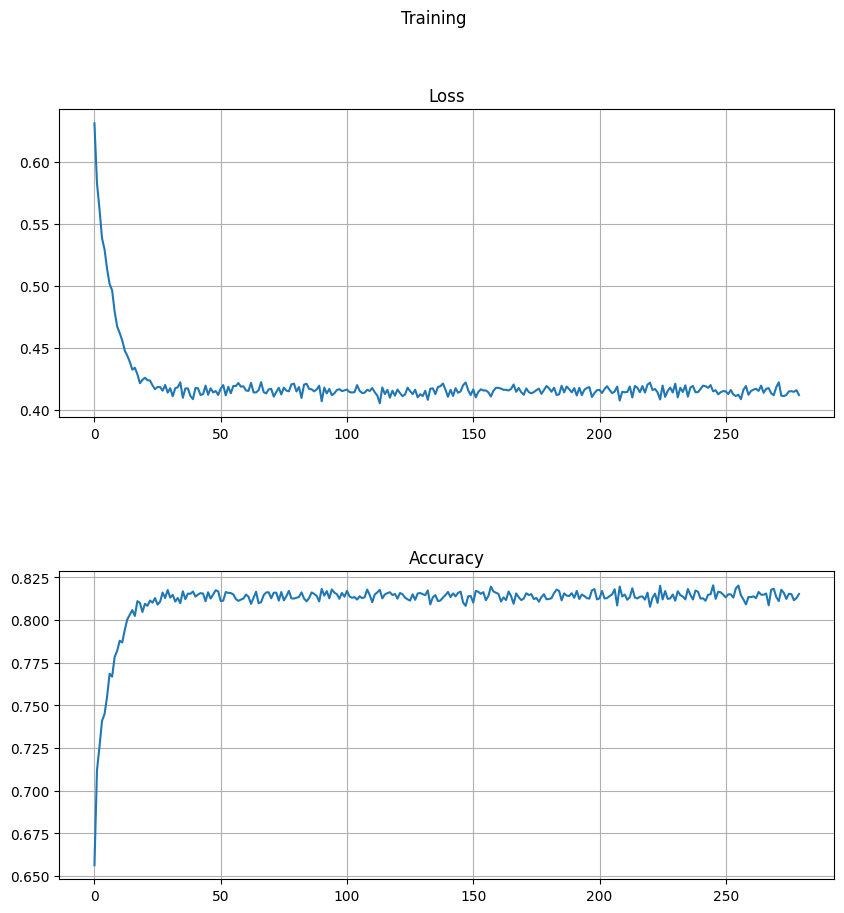

In [69]:
input_size = X_train.shape[1]
num_classes = len(torch.unique(y_train))

# Initialize the model
model = ModelDNN(input_size=input_size, num_classes=num_classes, first_layer_neuron=512, hidden_layers_neurons=[128, 64, 32, 16])
epochs = 500
batch_size = 32
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=X_train,
    y=y_train,
    print_every=200,
    learning_rate_decay=0.9
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [70]:
calculate_metrics(model(X_test), y_test)

{'accuracy': 0.6991071701049805,
 'precision': 0.7003295479868594,
 'recall': 0.6991071428571428,
 'f1_score': 0.698994868597343}

Epoch: 49, train loss: 0.62911, Accuracy: 62.500000: 100%|██████████| 50/50 [02:23<00:00,  2.87s/it] 


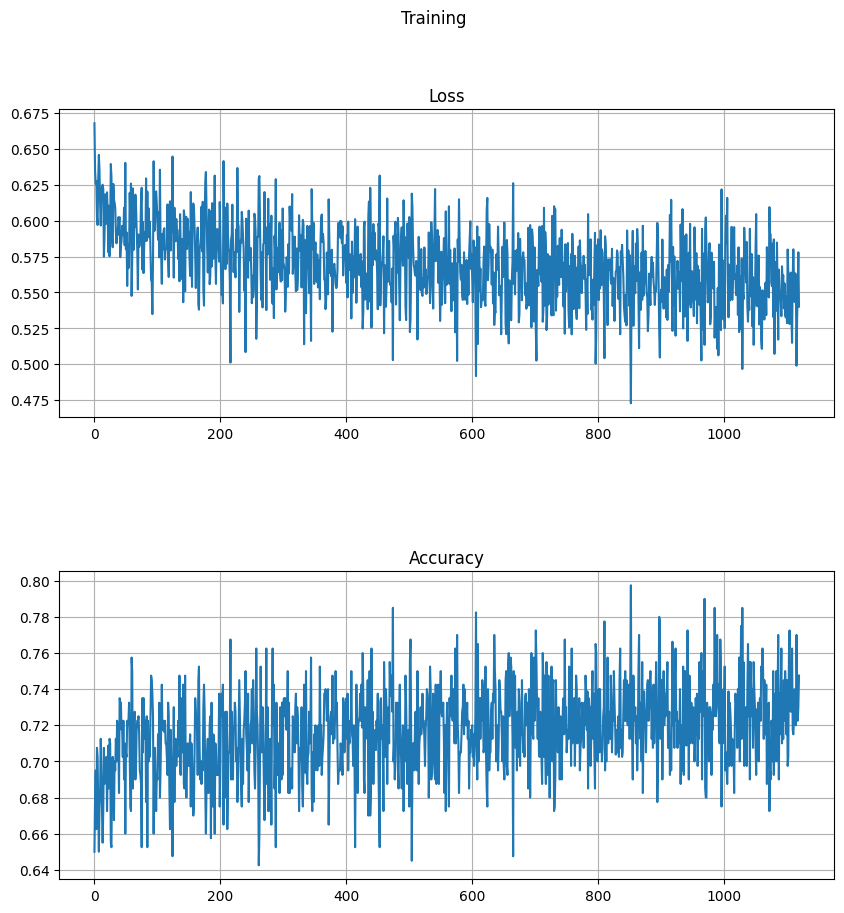

In [72]:
lda = StepwiseLDA(n_components=35)
lda.fit(X_train.numpy(), y_train.numpy())
# Get input size
input_size = lda.transform(X_test.numpy()).real.shape[1]  # Number of features after LDA transformation

# Initialize the model correctly
model = ModelDNN(
    input_size=input_size, 
    num_classes=np.unique(y_test.numpy()).size, 
    first_layer_neuron=512, 
    hidden_layers_neurons=[128, 64, 32, 16],
    activation=torch.nn.Tanh
)
epochs = 50
batch_size = 8
learning_rate = 1e-2

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=torch.tensor(lda.transform(X_train.numpy()).real).float(),
    y=y_train,
    print_every=200,
    learning_rate_decay=0.95
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [73]:
calculate_metrics(model(torch.tensor(lda.transform(X_test.numpy()).real).float()), y_test)

{'accuracy': 0.7174107432365417,
 'precision': 0.7174409620822707,
 'recall': 0.7174107142857142,
 'f1_score': 0.7174222636754813}

Epoch: 49, train loss: 0.13230, Accuracy: 100.000000: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it]


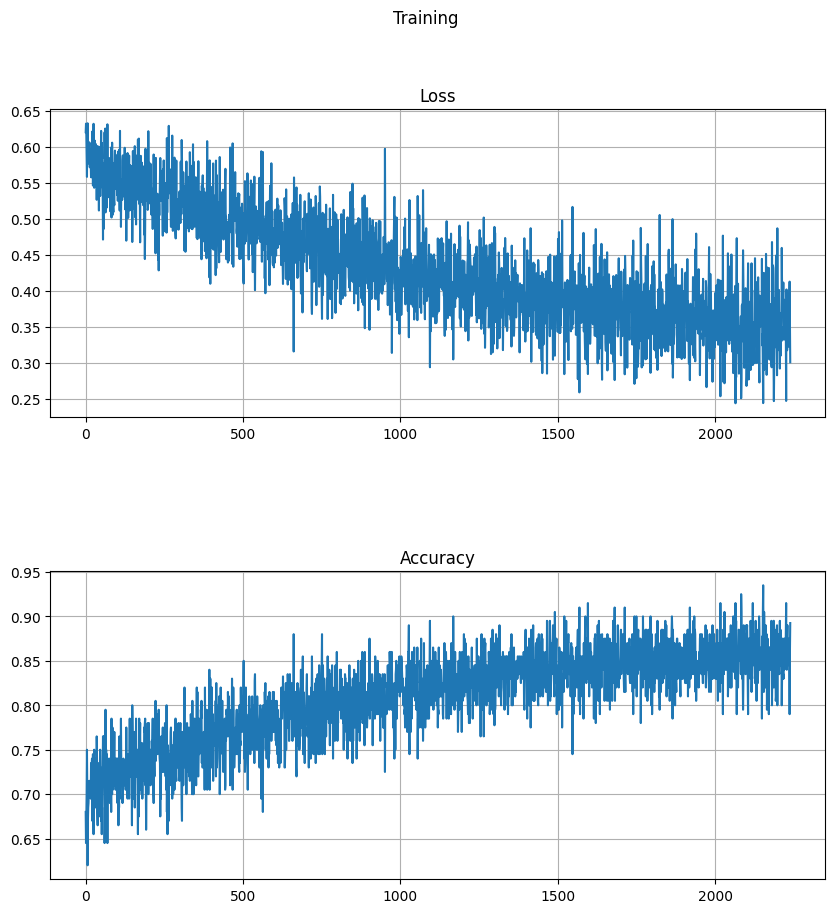

In [75]:
lda = StepwiseLDA(n_components=35)
lda.fit(X_train.numpy(), y_train.numpy())
# Get input size
input_size = lda.transform(X_test.numpy()).real.shape[1]  # Number of features after LDA transformation

# Initialize the model correctly
model = ModelDNN(
    input_size=input_size, 
    num_classes=np.unique(y_test.numpy()).size, 
    first_layer_neuron=512, 
    hidden_layers_neurons=[128, 64, 32, 16],
    activation=torch.nn.Tanh
)
epochs = 50
batch_size = 4
learning_rate = 1e-3

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=torch.tensor(lda.transform(X_train.numpy()).real).float(),
    y=y_train,
    print_every=200,
    learning_rate_decay=0.95
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [76]:
calculate_metrics(model(torch.tensor(lda.transform(X_test.numpy()).real).float()), y_test)

{'accuracy': 0.6660714149475098,
 'precision': 0.666224535554132,
 'recall': 0.6660714285714285,
 'f1_score': 0.6661049757455725}

Epoch: 49, train loss: 0.61031, Accuracy: 62.500000: 100%|██████████| 50/50 [01:14<00:00,  1.49s/it] 


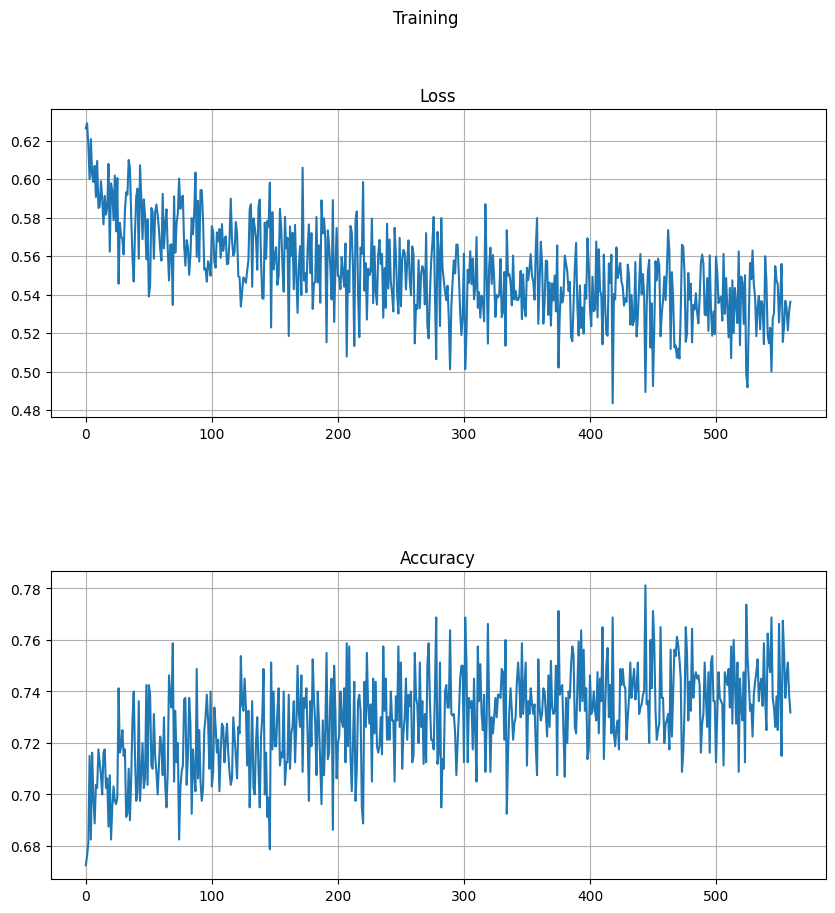

In [78]:
lda = StepwiseLDA(n_components=35)
lda.fit(X_train.numpy(), y_train.numpy())
# Get input size
input_size = lda.transform(X_test.numpy()).real.shape[1]  # Number of features after LDA transformation

# Initialize the model correctly
model = ModelDNN(
    input_size=input_size, 
    num_classes=np.unique(y_test.numpy()).size, 
    first_layer_neuron=512, 
    hidden_layers_neurons=[128, 64, 32, 16],
    activation=torch.nn.Tanh
)
epochs = 50
batch_size = 16
learning_rate = 1e-2

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=torch.tensor(lda.transform(X_train.numpy()).real).float(),
    y=y_train,
    print_every=200,
    learning_rate_decay=0.95
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

Epoch: 49, train loss: 0.55307, Accuracy: 68.750000: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it] 


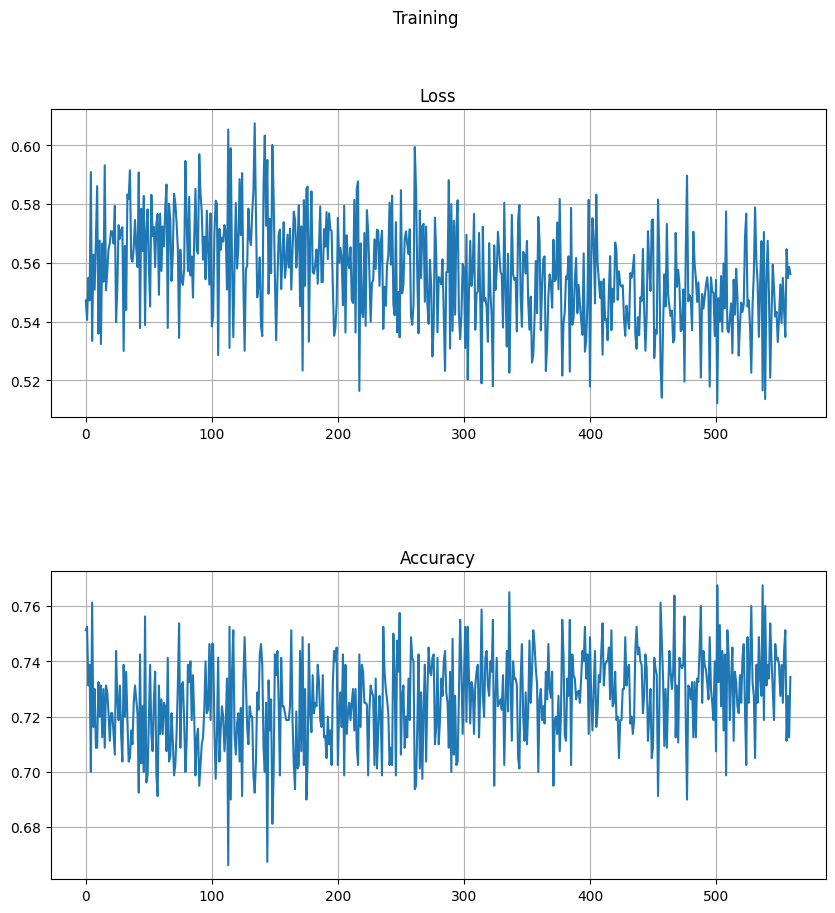

In [79]:
epochs = 50
batch_size = 16
learning_rate = 1e-2

loss, accuracy = train(
    epochs=epochs, 
    batch_size=batch_size,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model.parameters(), lr=learning_rate),
    model=model,
    x=torch.tensor(lda.transform(X_train.numpy()).real).float(),
    y=y_train,
    print_every=200,
    learning_rate_decay=0.95
)

running_mean = epochs
plt.figure(figsize=(10, 10))
plt.suptitle("Training")

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(np.array(loss).reshape(-1, running_mean).mean(axis=1))
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(np.array(accuracy).reshape(-1, running_mean).mean(axis=1))

plt.grid()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [80]:
calculate_metrics(model(torch.tensor(lda.transform(X_test.numpy()).real).float()), y_test)

{'accuracy': 0.7241071462631226,
 'precision': 0.724097735552916,
 'recall': 0.7241071428571428,
 'f1_score': 0.7241018618698819}